# Lab Report - 7 + 8

**Name**: Nimish Kashyap <br/>
**Reg. No:** 20BRS1049 <br/>
**Date:** 2/2/23 and 9/2/23

#### Questions:


1. L2 regularization using tensorflow playground with rate of 0.01

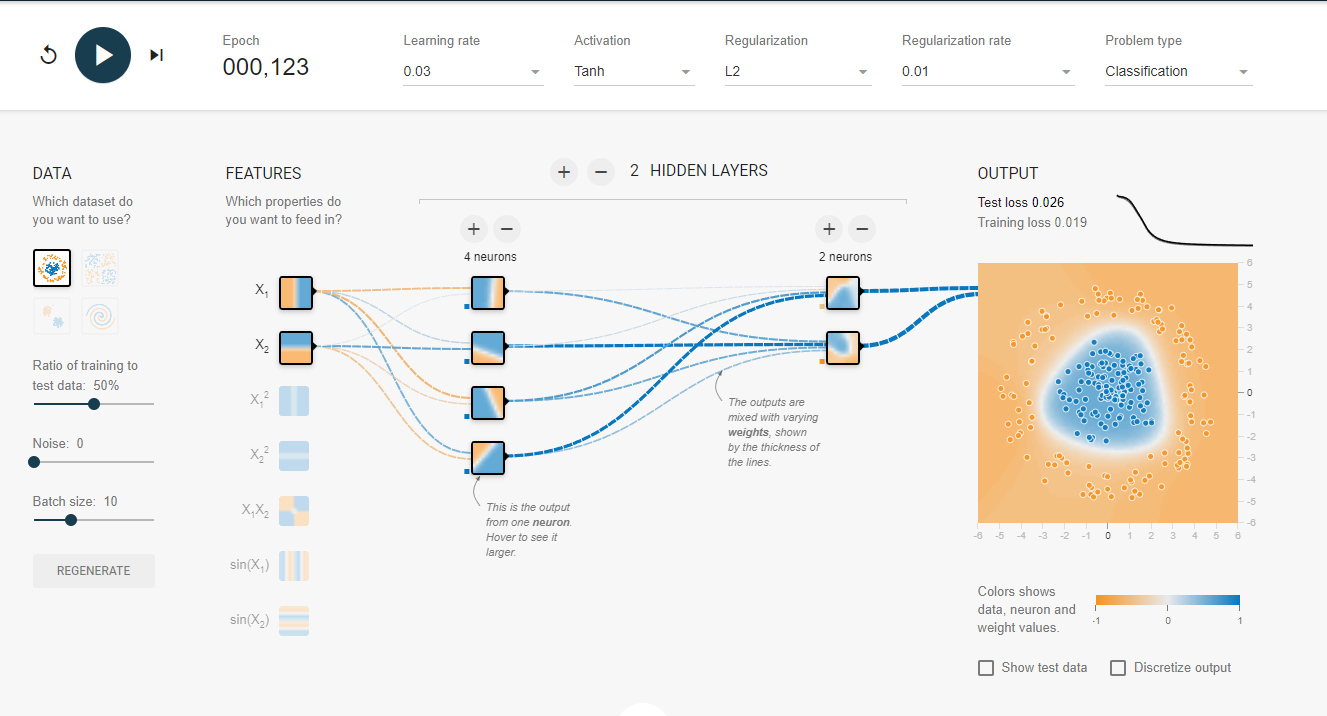

2. Try network.py with cross-entropy, L2 regularization.

In [ ]:
"""network2.py
~~~~~~~~~~~~~~
An improved version of network.py, implementing the stochastic
gradient descent learning algorithm for a feedforward neural network.
Improvements include the addition of the cross-entropy cost function,
regularization, and better initialization of network weights.  Note
that I have focused on making the code simple, easily readable, and
easily modifiable.  It is not optimized, and omits many desirable
features.
"""

#### Libraries
# Standard library
import json
import random
import sys

# Third-party libraries
import numpy as np


#### Define the quadratic and cross-entropy cost functions

class QuadraticCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.
        """
        return 0.5*np.linalg.norm(a-y)**2

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer."""
        return (a-y) * sigmoid_prime(z)


class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.  Note that np.nan_to_num is used to ensure numerical
        stability.  In particular, if both ``a`` and ``y`` have a 1.0
        in the same slot, then the expression (1-y)*np.log(1-a)
        returns nan.  The np.nan_to_num ensures that that is converted
        to the correct value (0.0).
        """
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer.  Note that the
        parameter ``z`` is not used by the method.  It is included in
        the method's parameters in order to make the interface
        consistent with the delta method for other cost classes.
        """
        return (a-y)


#### Main Network class
class Network(object):

    def __init__(self, sizes, cost=CrossEntropyCost):
        """The list ``sizes`` contains the number of neurons in the respective
        layers of the network.  For example, if the list was [2, 3, 1]
        then it would be a three-layer network, with the first layer
        containing 2 neurons, the second layer 3 neurons, and the
        third layer 1 neuron.  The biases and weights for the network
        are initialized randomly, using
        ``self.default_weight_initializer`` (see docstring for that
        method).
        """
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost=cost

    def default_weight_initializer(self):
        """Initialize each weight using a Gaussian distribution with mean 0
        and standard deviation 1 over the square root of the number of
        weights connecting to the same neuron.  Initialize the biases
        using a Gaussian distribution with mean 0 and standard
        deviation 1.
        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.
        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
        """Initialize the weights using a Gaussian distribution with mean 0
        and standard deviation 1.  Initialize the biases using a
        Gaussian distribution with mean 0 and standard deviation 1.
        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.
        This weight and bias initializer uses the same approach as in
        Chapter 1, and is included for purposes of comparison.  It
        will usually be better to use the default weight initializer
        instead.
        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda = 0.0,
            evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False,
            early_stopping_n = 0):
        """Train the neural network using mini-batch stochastic gradient
        descent.  The ``training_data`` is a list of tuples ``(x, y)``
        representing the training inputs and the desired outputs.  The
        other non-optional parameters are self-explanatory, as is the
        regularization parameter ``lmbda``.  The method also accepts
        ``evaluation_data``, usually either the validation or test
        data.  We can monitor the cost and accuracy on either the
        evaluation data or the training data, by setting the
        appropriate flags.  The method returns a tuple containing four
        lists: the (per-epoch) costs on the evaluation data, the
        accuracies on the evaluation data, the costs on the training
        data, and the accuracies on the training data.  All values are
        evaluated at the end of each training epoch.  So, for example,
        if we train for 30 epochs, then the first element of the tuple
        will be a 30-element list containing the cost on the
        evaluation data at the end of each epoch. Note that the lists
        are empty if the corresponding flag is not set.
        """

        # early stopping functionality:
        best_accuracy=1

        training_data = list(training_data)
        n = len(training_data)

        if evaluation_data:
            evaluation_data = list(evaluation_data)
            n_data = len(evaluation_data)

        # early stopping functionality:
        best_accuracy=0
        no_accuracy_change=0

        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, eta, lmbda, len(training_data))

            print("Epoch %s training complete" % j)

            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print("Accuracy on training data: {} / {}".format(accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print("Accuracy on evaluation data: {} / {}".format(self.accuracy(evaluation_data), n_data))

            # Early stopping:
            if early_stopping_n > 0:
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    no_accuracy_change = 0
                    #print("Early-stopping: Best so far {}".format(best_accuracy))
                else:
                    no_accuracy_change += 1

                if (no_accuracy_change == early_stopping_n):
                    #print("Early-stopping: No accuracy change in last epochs: {}".format(early_stopping_n))
                    return evaluation_cost, evaluation_accuracy, training_cost, training_accuracy

        return evaluation_cost, evaluation_accuracy, \
            training_cost, training_accuracy

    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        """Update the network's weights and biases by applying gradient
        descent using backpropagation to a single mini batch.  The
        ``mini_batch`` is a list of tuples ``(x, y)``, ``eta`` is the
        learning rate, ``lmbda`` is the regularization parameter, and
        ``n`` is the total size of the training data set.
        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        """Return the number of inputs in ``data`` for which the neural
        network outputs the correct result. The neural network's
        output is assumed to be the index of whichever neuron in the
        final layer has the highest activation.
        The flag ``convert`` should be set to False if the data set is
        validation or test data (the usual case), and to True if the
        data set is the training data. The need for this flag arises
        due to differences in the way the results ``y`` are
        represented in the different data sets.  In particular, it
        flags whether we need to convert between the different
        representations.  It may seem strange to use different
        representations for the different data sets.  Why not use the
        same representation for all three data sets?  It's done for
        efficiency reasons -- the program usually evaluates the cost
        on the training data and the accuracy on other data sets.
        These are different types of computations, and using different
        representations speeds things up.  More details on the
        representations can be found in
        mnist_loader.load_data_wrapper.
        """
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]

        result_accuracy = sum(int(x == y) for (x, y) in results)
        return result_accuracy

    def total_cost(self, data, lmbda, convert=False):
        """Return the total cost for the data set ``data``.  The flag
        ``convert`` should be set to False if the data set is the
        training data (the usual case), and to True if the data set is
        the validation or test data.  See comments on the similar (but
        reversed) convention for the ``accuracy`` method, above.
        """
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
            cost += 0.5*(lmbda/len(data))*sum(np.linalg.norm(w)**2 for w in self.weights) # '**' - to the power of.
        return cost

    def save(self, filename):
        """Save the neural network to the file ``filename``."""
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()

#### Loading a Network
def load(filename):
    """Load a neural network from the file ``filename``.  Returns an
    instance of Network.
    """
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    cost = getattr(sys.modules[__name__], data["cost"])
    net = Network(data["sizes"], cost=cost)
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net

#### Miscellaneous functions
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the j'th position
    and zeroes elsewhere.  This is used to convert a digit (0...9)
    into a corresponding desired output from the neural network.
    """
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))


In [ ]:
"""
mnist_loader
~~~~~~~~~~~~
A library to load the MNIST image data.  For details of the data
structures that are returned, see the doc strings for ``load_data``
and ``load_data_wrapper``.  In practice, ``load_data_wrapper`` is the
function usually called by our neural network code.
"""

#### Libraries
# Standard library
import pickle
import gzip

# Third-party libraries
import numpy as np

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.
    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.
    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.
    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.
    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.
    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.
    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.
    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return 

In [ ]:
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

In [ ]:
net = Network([784, 30, 10], cost=CrossEntropyCost)
net.large_weight_initializer()
net.SGD(training_data, 30, 10, 0.1, lmbda = 5.0,evaluation_data=validation_data,monitor_evaluation_accuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 8706 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 9036 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 9162 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 9237 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 9318 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 9344 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 9389 / 10000
Epoch 7 training complete
Accuracy on evaluation data: 9397 / 10000
Epoch 8 training complete
Accuracy on evaluation data: 9414 / 10000
Epoch 9 training complete
Accuracy on evaluation data: 9451 / 10000
Epoch 10 training complete
Accuracy on evaluation data: 9463 / 10000
Epoch 11 training complete
Accuracy on evaluation data: 9481 / 10000
Epoch 12 training complete
Accuracy on evaluation data: 9522 / 10000
Epoch 13 training complete
Accuracy on evaluation data: 9525 / 10000
Epoch 14 training complete
Accuracy on evalu

([],
 [8706,
  9036,
  9162,
  9237,
  9318,
  9344,
  9389,
  9397,
  9414,
  9451,
  9463,
  9481,
  9522,
  9525,
  9549,
  9554,
  9556,
  9579,
  9592,
  9601,
  9595,
  9606,
  9595,
  9605,
  9618,
  9622,
  9639,
  9652,
  9628,
  9638],
 [],
 [])

3. a) 

In [ ]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.9.2


In [ ]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ezkdu9mk
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-ezkdu9mk
  Resolved https://github.com/tensorflow/docs to commit 81dd2cc4ed0611f029a50513d6e5d5acf5c69b12
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=180353 sha256=7f65fc0022fbb2c1b4a910616463fcaa591977c7915da08345fcd9f8aa780e05
  Stored in directory: /tmp/pip-ephem-wheel-cache-sbohqhu6/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs


In [ ]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [ ]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [ ]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 [==============================] - 127s 0us/step


In [ ]:
FEATURES = 28

In [ ]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [ ]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [ ]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


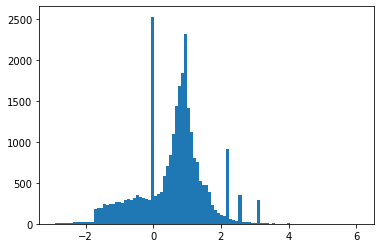

In [ ]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [ ]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [ ]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [ ]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

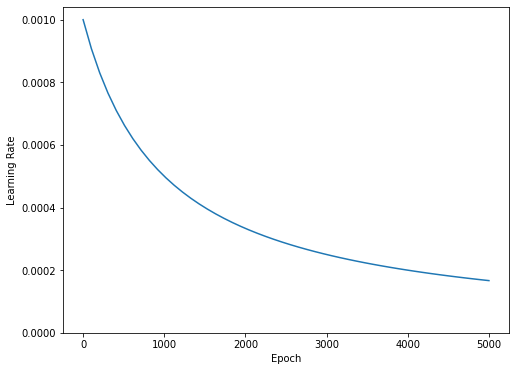

In [ ]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [ ]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [ ]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

In [ ]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [ ]:

size_histories = {}

In [ ]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4729,  binary_crossentropy:0.8097,  loss:0.8097,  val_accuracy:0.4350,  val_binary_crossentropy:0.7993,  val_loss:0.7993,  
....................................................................................................
Epoch: 100, accuracy:0.5925,  binary_crossentropy:0.6264,  loss:0.6264,  val_accuracy:0.5800,  val_binary_crossentropy:0.6237,  val_loss:0.6237,  
............................................................

(0.5, 0.7)

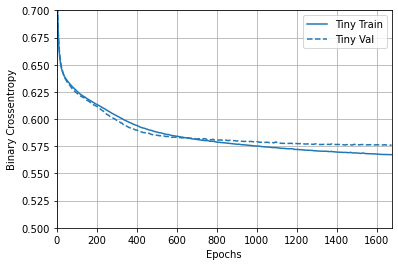

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [ ]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [ ]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small', max_epochs=1000)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4728,  binary_crossentropy:0.7757,  loss:0.7757,  val_accuracy:0.4720,  val_binary_crossentropy:0.7158,  val_loss:0.7158,  
....................................................................................................
Epoch: 100, accuracy:0.6233,  binary_crossentropy:0.6125,  loss:0.6125,  

In [ ]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [ ]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium", max_epochs=1000)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                1856      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4984,  binary_crossentropy:0.6899,  loss:0.6899,  val_accuracy:0.5080,  val_binary_crossentropy:0.6744,  val_loss:0.6744,  
....................................

In [ ]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [ ]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large", max_epochs=1000)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               14848     
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5101,  binary_crossentropy

Text(0.5, 0, 'Epochs [Log Scale]')

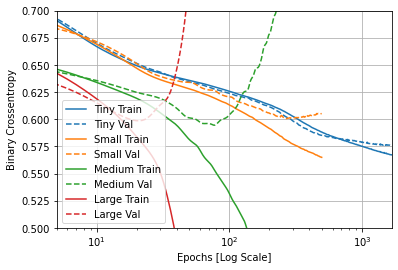

In [ ]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [ ]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

3. b)

In [ ]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [ ]:
# Importing necessary packages and functions required
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns 
import warnings 
warnings.filterwarnings('ignore')
# Reading the dataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data'
crime = pd.read_csv(url, header=None, na_values=['?'])
crime.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


In [ ]:
crime[127].describe()

count    1994.000000
mean        0.237979
std         0.232985
min         0.000000
25%         0.070000
50%         0.150000
75%         0.330000
max         1.000000
Name: 127, dtype: float64

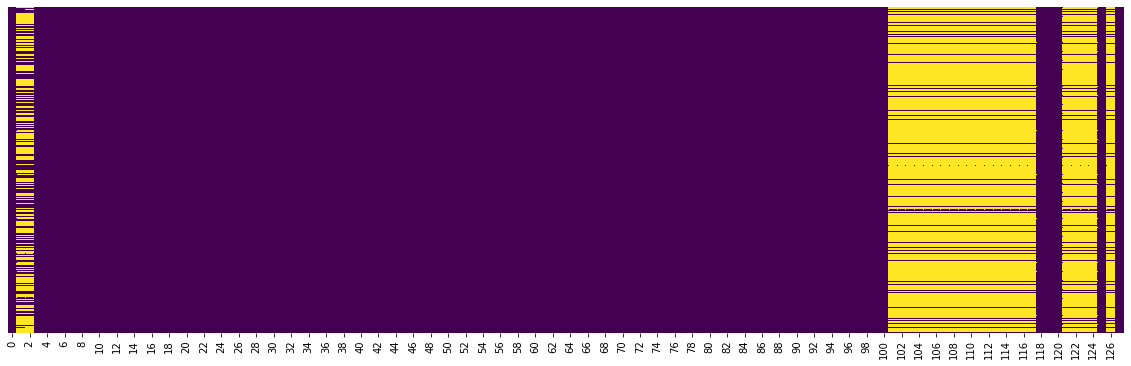

In [ ]:
plt.figure(figsize=(20, 6))
sns.heatmap(crime.isnull(),yticklabels=False,cbar=False,cmap='viridis')

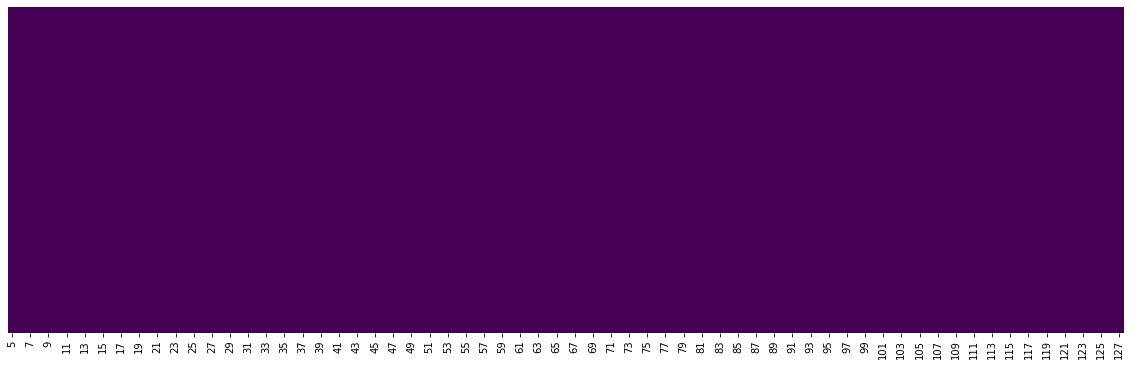

In [ ]:
crime.drop([0, 1, 2, 3, 4], axis=1, inplace=True)
# removing missing values
crime.dropna(inplace=True)
plt.figure(figsize=(20, 6))
sns.heatmap(crime.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
X = crime.drop(127, axis=1)
y = crime[127]



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state=1)



In [ ]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
print ("iNTERCEPT : ",linreg.intercept_)
print ("CO-EFFICIENT : ",linreg.coef_)

iNTERCEPT :  0.9922125287585475
CO-EFFICIENT :  [-3.93018330e+00  7.31324716e-01 -3.01181421e-01 -2.96634778e-01
 -1.83170801e-01  2.81575284e-01 -1.48744636e+00 -4.84695533e-01
  1.24104896e+00 -5.32282788e-01  4.64331123e+00 -1.17079618e-01
  1.04229108e+00  1.36950901e-01 -3.12434116e-01 -1.16489196e+00
  5.37252913e-01  7.49655606e-01 -8.02500871e-02  8.42449509e-01
 -1.98951720e-01 -3.17193999e-01 -4.31217869e-01  1.19357660e-01
 -1.83148129e-01  2.11602690e-01 -1.57441950e-01 -1.03051105e+00
  1.49628176e+00  1.86093900e-01 -1.12289917e+00 -1.13107576e-02
  1.22670519e-01  1.46348876e-01 -1.64172731e-01 -3.73690589e-02
  1.92733806e-01  4.34808503e-01  2.32870361e+00 -5.15176228e-01
  2.64683754e+00 -5.48075999e+00  9.63873430e-01 -1.15021921e+00
 -1.15575665e+00  1.10543276e+00  2.41469970e-01 -6.32209680e-01
  6.01741978e-01  8.37645340e-02  1.05006759e-01 -2.58807800e-01
  5.31513493e-01 -8.57090632e-01 -3.29684470e-01  6.61114510e-01
 -5.61884511e-01  6.27806334e-01  2.798480

In [ ]:
y_pred = linreg.predict(X_test)

In [ ]:

from sklearn.metrics import r2_score
from sklearn import metrics
print("R-Square Value",r2_score(y_test,y_pred))
print("\n")
print ("mean_absolute_error :",metrics.mean_absolute_error(y_test, y_pred))
print("\n")
print ("mean_squared_error : ",metrics.mean_squared_error(y_test, y_pred))
print("\n")
print ("root_mean_squared_error : ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R-Square Value 0.197044562954102


mean_absolute_error : 0.16725155824888047


mean_squared_error :  0.04986345422693336


root_mean_squared_error :  0.22330126337961764


In [ ]:
from sklearn.linear_model import Ridge
ridgereg = Ridge(alpha=0, normalize=True)
ridgereg.fit(X_train, y_train)
y_pred = ridgereg.predict(X_test)

In [ ]:
from sklearn import metrics
print("R-Square Value",r2_score(y_test,y_pred))
print("\n")
print ("mean_absolute_error :",metrics.mean_absolute_error(y_test, y_pred))
print("\n")
print ("mean_squared_error : ",metrics.mean_squared_error(y_test, y_pred))
print("\n")
print ("root_mean_squared_error : ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R-Square Value 0.19704456295992367


mean_absolute_error : 0.16725155824795365


mean_squared_error :  0.04986345422657184


root_mean_squared_error :  0.22330126337880812


In [ ]:
ridgereg = Ridge(alpha=0.1, normalize=True)
ridgereg.fit(X_train, y_train)
y_pred = ridgereg.predict(X_test)

In [ ]:

from sklearn import metrics
print("R-Square Value",r2_score(y_test,y_pred))
print("\n")
print ("mean_absolute_error :",metrics.mean_absolute_error(y_test, y_pred))
print("\n")
print ("mean_squared_error : ",metrics.mean_squared_error(y_test, y_pred))
print("\n")
print ("root_mean_squared_error : ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R-Square Value 0.5347697501566351


mean_absolute_error : 0.12769772972161883


mean_squared_error :  0.028890753082631376


root_mean_squared_error :  0.16997280100837125


In [ ]:
print(ridgereg.coef_)

[-5.77226675e-03  2.26721774e-02  4.98857382e-02 -6.70174168e-02
 -1.83566112e-02  5.26888536e-02  1.17689929e-02 -5.72468914e-02
  1.52761058e-03  4.29131248e-02  1.04586550e-04 -1.85621890e-02
  5.07008262e-02 -9.63941391e-02 -1.58499805e-01 -3.28082329e-01
 -1.43015949e-02  8.97253556e-02 -1.10520025e-01  8.02961453e-02
 -2.01498712e-02  7.77242382e-03 -8.07823610e-02 -1.39148634e-01
 -1.19008810e-02  1.00148033e-01  3.61850806e-02 -9.71628046e-02
  6.94268658e-02 -8.81688130e-02 -9.79415666e-02 -4.99145470e-03
  1.28541873e-01 -4.15102106e-02 -1.35952164e-01  4.09752240e-02
  7.00727085e-02 -1.86859042e-02  5.95401646e-02  6.28621417e-02
 -3.91478791e-02  8.48551263e-03  7.31545217e-02 -1.28265573e-01
 -1.22240655e-01 -7.02441332e-02 -7.10900893e-02 -6.33671556e-02
  1.01095274e-01 -5.22454503e-02  1.15465301e-01 -7.35016006e-02
 -4.79847841e-03 -1.10878367e-01  6.49567154e-02  4.12339751e-02
 -1.06606017e-02  1.32494298e-03  1.81063822e-02 -1.85567810e-03
 -1.32904914e-02  3.94493

In [ ]:
alpha_range = 10.**np.arange(-2, 3)
alpha_range
np.array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
# select the best alpha with RidgeCV
from sklearn.linear_model import RidgeCV
ridgeregcv = RidgeCV(alphas=alpha_range, normalize=True, scoring='neg_mean_squared_error')
ridgeregcv.fit(X_train, y_train)
ridgeregcv.alpha_
1.0
# predict method uses the best alpha value
y_pred = ridgeregcv.predict(X_test)
# calculate R^2 value, MAE, MSE, RMSE

from sklearn import metrics
print("R-Square Value",r2_score(y_test,y_pred))
print("\n")
print ("mean_absolute_error :",metrics.mean_absolute_error(y_test, y_pred))
print("\n")
print ("mean_squared_error : ",metrics.mean_squared_error(y_test, y_pred))
print("\n")
print ("root_mean_squared_error : ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R-Square Value 0.5318623469518373


mean_absolute_error : 0.13256644483823504


mean_squared_error :  0.02907130253772322


root_mean_squared_error :  0.17050308659295063


In [ ]:
from sklearn.linear_model import Lasso
lassoreg = Lasso(alpha=0.001, normalize=True)
lassoreg.fit(X_train, y_train)
print(lassoreg.coef_)

[ 0.          0.          0.         -0.25339884  0.          0.
  0.         -0.         -0.          0.          0.          0.
 -0.         -0.         -0.         -0.17865705  0.          0.
 -0.         -0.         -0.         -0.         -0.         -0.02230294
 -0.          0.          0.          0.          0.0998841  -0.
  0.         -0.          0.01893786 -0.         -0.03169217  0.
  0.         -0.          0.11479343  0.          0.          0.
  0.         -0.16845012 -0.27294066 -0.         -0.         -0.
 -0.          0.          0.          0.          0.         -0.
  0.          0.          0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.
  0.         -0.          0.          0.02709397 -0.          0.
 -0.         -0.          0.          0.          0.          0.
  0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.          0.00233805
  0.15404

In [ ]:
lassoreg = Lasso(alpha=0.01, normalize=True)
lassoreg.fit(X_train, y_train)
print(lassoreg.coef_)

[ 0.          0.          0.         -0.04214088  0.          0.
  0.          0.          0.         -0.          0.          0.
 -0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.          0.          0.          0.
  0.         -0.          0.         -0.         -0.          0.
  0.         -0.          0.          0.          0.          0.
  0.         -0.         -0.29715868 -0.         -0.         -0.
 -0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.
  0.         -0.          0.          0.         -0.          0.
 -0.         -0.          0.          0.         -0.          0.
  0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.          0.
  0.          0.         

In [ ]:
# calculate RMSE (for alpha=0.01)
y_pred = lassoreg.predict(X_test)
# calculate MAE, MSE, RMSE
# calculate R^2 value, MAE, MSE, RMSE

from sklearn import metrics
print("R-Square Value",r2_score(y_test,y_pred))
print("\n")
print ("mean_absolute_error :",metrics.mean_absolute_error(y_test, y_pred))
print("\n")
print ("mean_squared_error : ",metrics.mean_squared_error(y_test, y_pred))
print("\n")
print ("root_mean_squared_error : ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R-Square Value 0.3241322659149901


mean_absolute_error : 0.16889755277533727


mean_squared_error :  0.04197132028397071


root_mean_squared_error :  0.20486903202770962


In [ ]:
from sklearn.linear_model import LassoCV
lassoregcv = LassoCV(n_alphas=100, normalize=True, random_state=1)
lassoregcv.fit(X_train, y_train)
print('alpha : ',lassoregcv.alpha_)
print(lassoregcv.coef_)

alpha :  0.0016878682947072093
[ 0.          0.          0.         -0.26320105  0.          0.
  0.          0.          0.          0.          0.          0.
 -0.         -0.         -0.         -0.1285917   0.          0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.          0.         -0.          0.          0.11511909  0.
  0.         -0.          0.         -0.         -0.          0.
  0.         -0.          0.04667596  0.          0.          0.08875875
  0.         -0.09735466 -0.3276063  -0.         -0.         -0.
 -0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.
  0.         -0.          0.          0.         -0.          0.
 -0.         -0.          0.          0.          0.          0.
  0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.         -0

In [ ]:
y_pred = lassoregcv.predict(X_test)
# calculate R^2 value, MAE, MSE, RMSE

from sklearn import metrics
print("R-Square Value",r2_score(y_test,y_pred))
print("\n")
print ("mean_absolute_error :",metrics.mean_absolute_error(y_test, y_pred))
print("\n")
print ("mean_squared_error : ",metrics.mean_squared_error(y_test, y_pred))
print("\n")
print ("root_mean_squared_error : ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R-Square Value 0.5506049113488303


mean_absolute_error : 0.134166281828735


mean_squared_error :  0.02790739111899851


root_mean_squared_error :  0.1670550541558037


Lab report 8:

Question:

1. Try L1 regularization with network2.py

In [ ]:
"""network2.py
~~~~~~~~~~~~~~

An improved version of network.py, implementing the stochastic
gradient descent learning algorithm for a feedforward neural network.
Improvements include the addition of the cross-entropy cost function,
regularization, and better initialization of network weights.  Note
that I have focused on making the code simple, easily readable, and
easily modifiable.  It is not optimized, and omits many desirable
features.

"""

#### Libraries
# Standard library
import json
import random
import sys

# Third-party libraries
import numpy as np


#### Define the quadratic and cross-entropy cost functions
class QuadraticCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.

        """
        return 0.5*np.linalg.norm(a-y)**2

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer."""
        return (a-y) * sigmoid_prime(z)


class CrossEntropyCost(object):
    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.  Note that np.nan_to_num is used to ensure numerical
        stability.  In particular, if both ``a`` and ``y`` have a 1.0
        in the same slot, then the expression (1-y)*np.log(1-a)
        returns nan.  The np.nan_to_num ensures that that is converted
        to the correct value (0.0).

        """
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer.  Note that the
        parameter ``z`` is not used by the method.  It is included in
        the method's parameters in order to make the interface
        consistent with the delta method for other cost classes.

        """
        return (a-y)


#### Main Network class
class Network(object):

    def __init__(self, sizes, cost=CrossEntropyCost):
        """The list ``sizes`` contains the number of neurons in the respective
        layers of the network.  For example, if the list was [2, 3, 1]
        then it would be a three-layer network, with the first layer
        containing 2 neurons, the second layer 3 neurons, and the
        third layer 1 neuron.  The biases and weights for the network
        are initialized randomly, using
        ``self.default_weight_initializer`` (see docstring for that
        method).

        """
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost=cost

    def default_weight_initializer(self):
        """Initialize each weight using a Gaussian distribution with mean 0
        and standard deviation 1 over the square root of the number of
        weights connecting to the same neuron.  Initialize the biases
        using a Gaussian distribution with mean 0 and standard
        deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
        """Initialize the weights using a Gaussian distribution with mean 0
        and standard deviation 1.  Initialize the biases using a
        Gaussian distribution with mean 0 and standard deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        This weight and bias initializer uses the same approach as in
        Chapter 1, and is included for purposes of comparison.  It
        will usually be better to use the default weight initializer
        instead.

        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda = 0.0,
            evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False):
        """Train the neural network using mini-batch stochastic gradient
        descent.  The ``training_data`` is a list of tuples ``(x, y)``
        representing the training inputs and the desired outputs.  The
        other non-optional parameters are self-explanatory, as is the
        regularization parameter ``lmbda``.  The method also accepts
        ``evaluation_data``, usually either the validation or test
        data.  We can monitor the cost and accuracy on either the
        evaluation data or the training data, by setting the
        appropriate flags.  The method returns a tuple containing four
        lists: the (per-epoch) costs on the evaluation data, the
        accuracies on the evaluation data, the costs on the training
        data, and the accuracies on the training data.  All values are
        evaluated at the end of each training epoch.  So, for example,
        if we train for 30 epochs, then the first element of the tuple
        will be a 30-element list containing the cost on the
        evaluation data at the end of each epoch. Note that the lists
        are empty if the corresponding flag is not set.

        """
        training_data = list(training_data)
        if(evaluation_data): 
          evaluation_data= list(evaluation_data)
          n_data = len(evaluation_data)
        n = len(training_data)
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, eta, lmbda, len(training_data))
            
            print("Epoch {} training complete".format(j+1))
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print("Accuracy on training data: {:2f} %".format(
                    (accuracy/n)*100))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print("Accuracy on evaluation data: {:2f} %".format(
                    (self.accuracy(evaluation_data)/n_data)*100))
            print
        return evaluation_cost, evaluation_accuracy, \
            training_cost, training_accuracy

    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        """Update the network's weights and biases by applying gradient
        descent using backpropagation to a single mini batch.  The
        ``mini_batch`` is a list of tuples ``(x, y)``, ``eta`` is the
        learning rate, ``lmbda`` is the regularization parameter, and
        ``n`` is the total size of the training data set.
        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        """Return the number of inputs in ``data`` for which the neural
        network outputs the correct result. The neural network's
        output is assumed to be the index of whichever neuron in the
        final layer has the highest activation.

        The flag ``convert`` should be set to False if the data set is
        validation or test data (the usual case), and to True if the
        data set is the training data. The need for this flag arises
        due to differences in the way the results ``y`` are
        represented in the different data sets.  In particular, it
        flags whether we need to convert between the different
        representations.  It may seem strange to use different
        representations for the different data sets.  Why not use the
        same representation for all three data sets?  It's done for
        efficiency reasons -- the program usually evaluates the cost
        on the training data and the accuracy on other data sets.
        These are different types of computations, and using different
        representations speeds things up.  More details on the
        representations can be found in
        mnist_loader.load_data_wrapper.

        """
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

    def total_cost(self, data, lmbda, convert=False):
        """Return the total cost for the data set ``data``.  The flag
        ``convert`` should be set to False if the data set is the
        training data (the usual case), and to True if the data set is
        the validation or test data.  See comments on the similar (but
        reversed) convention for the ``accuracy`` method, above.
        """
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
        cost += 0.5*(lmbda/len(data))*sum(
            abs(np.linalg.norm(w)) for w in self.weights) # L1 Regularization
        return cost

    def save(self, filename):
        """Save the neural network to the file ``filename``."""
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()

#### Loading a Network
def load(filename):
    """Load a neural network from the file ``filename``.  Returns an
    instance of Network.
    """
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    cost = getattr(sys.modules[__name__], data["cost"])
    net = Network(data["sizes"], cost=cost)
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net

#### Miscellaneous functions
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the j'th position
    and zeroes elsewhere.  This is used to convert a digit (0...9)
    into a corresponding desired output from the neural network.

    """
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [ ]:
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

In [ ]:
net = Network([784, 30, 10], cost=CrossEntropyCost)
#net.large_weight_initializer()
net.SGD(training_data, 30, 10, 0.1, lmbda = 5.0,evaluation_data=validation_data,
    monitor_evaluation_accuracy=True)

Epoch 1 training complete
Accuracy on evaluation data: 92.610000 %
Epoch 2 training complete
Accuracy on evaluation data: 94.150000 %
Epoch 3 training complete
Accuracy on evaluation data: 94.990000 %
Epoch 4 training complete
Accuracy on evaluation data: 94.910000 %
Epoch 5 training complete
Accuracy on evaluation data: 95.390000 %
Epoch 6 training complete
Accuracy on evaluation data: 95.630000 %
Epoch 7 training complete
Accuracy on evaluation data: 95.720000 %
Epoch 8 training complete
Accuracy on evaluation data: 96.080000 %
Epoch 9 training complete
Accuracy on evaluation data: 95.990000 %
Epoch 10 training complete
Accuracy on evaluation data: 96.050000 %
Epoch 11 training complete
Accuracy on evaluation data: 96.010000 %
Epoch 12 training complete
Accuracy on evaluation data: 96.140000 %
Epoch 13 training complete
Accuracy on evaluation data: 96.080000 %
Epoch 14 training complete
Accuracy on evaluation data: 96.230000 %
Epoch 15 training complete
Accuracy on evaluation data: 9

([],
 [9261,
  9415,
  9499,
  9491,
  9539,
  9563,
  9572,
  9608,
  9599,
  9605,
  9601,
  9614,
  9608,
  9623,
  9623,
  9605,
  9626,
  9604,
  9630,
  9653,
  9639,
  9624,
  9635,
  9644,
  9642,
  9653,
  9632,
  9644,
  9628,
  9653],
 [],
 [])

2. Mean = 0 and SD = 1

In [ ]:
"""
A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.  Note that I have focused on making the code
simple, easily readable, and easily modifiable.  It is not optimized,
and omits many desirable features.
"""

import random
import numpy as np

class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and sd 1/sqrt(x).  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]  # np.random.randn(y, 1) -> create an array of random nos. following normal distribution of 1 dimension or a y X 1 matrix
        self.weights = [np.random.randn(y, x)/np.sqrt(x) # y X x matrix
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        training_data = list(training_data)
        n = len(training_data)

        if test_data:
            test_data = list(test_data)
            n_test = len(test_data)

        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print("Epoch {} : Accuracy: {:2f} %".format(j+1,(self.evaluate(test_data)/n_test)*100))
            else:
                print("Epoch {} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1]) # activations is the predicted, y is the target
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

In [ ]:
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

In [ ]:
net = Network([784, 30, 10])
#net.large_weight_initializer()
net.SGD(training_data, 10, 10, 0.1, test_data=validation_data)

Epoch 1 : Accuracy: 89.130000 %
Epoch 2 : Accuracy: 91.170000 %
Epoch 3 : Accuracy: 92.090000 %
Epoch 4 : Accuracy: 92.590000 %
Epoch 5 : Accuracy: 92.940000 %
Epoch 6 : Accuracy: 93.250000 %
Epoch 7 : Accuracy: 93.580000 %
Epoch 8 : Accuracy: 93.820000 %
Epoch 9 : Accuracy: 93.860000 %
Epoch 10 : Accuracy: 93.970000 %


3. 

In [ ]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Normalize the pixel values to the range of [0, 1].
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Add the channel dimension to the images.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
# Print the shapes of the data.
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [ ]:
def build_model(hp):
    inputs = keras.Input(shape=(28, 28, 1))
    # Model type can be MLP or CNN.
    model_type = hp.Choice("model_type", ["mlp", "cnn"])
    x = inputs
    if model_type == "mlp":
        x = layers.Flatten()(x)
        # Number of layers of the MLP is a hyperparameter.
        for i in range(hp.Int("mlp_layers", 1, 3)):
            # Number of units of each layer are
            # different hyperparameters with different names.
            x = layers.Dense(
                units=hp.Int(f"units_{i}", 32, 128, step=32), activation="relu",
            )(x)
    else:
        # Number of layers of the CNN is also a hyperparameter.
        for i in range(hp.Int("cnn_layers", 1, 3)):
            x = layers.Conv2D(
                hp.Int(f"filters_{i}", 32, 128, step=32),
                kernel_size=(3, 3),
                activation="relu",
            )(x)
            x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Flatten()(x)

    # A hyperparamter for whether to use dropout layer.
    if hp.Boolean("dropout"):
        x = layers.Dropout(0.5)(x)

    # The last layer contains 10 units,
    # which is the same as the number of classes.
    outputs = layers.Dense(units=10, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model.
    model.compile(
        loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam",
    )
    return model

In [ ]:
# Initialize the `HyperParameters` and set the values.
hp = keras_tuner.HyperParameters()
hp.values["model_type"] = "cnn"
# Build the model using the `HyperParameters`.
model = build_model(hp)
# Test if the model runs with our data.
model(x_train[:100])
# Print a summary of the model.
model.summary()

# Do the same for MLP model.
hp.values["model_type"] = "mlp"
model = build_model(hp)
model(x_train[:100])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________

In [ ]:
tuner = keras_tuner.RandomSearch(
    build_model,
    max_trials=10,
    # Do not resume the previous search in the same directory.
    overwrite=True,
    objective="val_accuracy",
    # Set a directory to store the intermediate results.
    directory="/tmp/tb",
)

In [ ]:
tuner.search(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=2,
    # Use the TensorBoard callback.
    # The logs will be write to "/tmp/tb_logs".
    callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")],
)

Trial 10 Complete [00h 02m 53s]
val_accuracy: 0.984083354473114

Best val_accuracy So Far: 0.987583339214325
Total elapsed time: 00h 15m 03s


In [ ]:
%load_ext tensorboard
%tensorboard --logdir /tmp/tb_logs

# !kill 5560

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>